In [68]:
import mysql.connector 
import pandas as pd
from pandas import DataFrame
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import config
from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split, cross_val_score
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from IPython.display import Image
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
cnx = mysql.connector .connect(
    host = config.host,
    user = config.user,
    passwd = config.passwd,
    database= 'Dog_Breeds'
)
cursor = cnx.cursor()

# cursor.close()
# cnx.close()

In [3]:
sq= """SELECT * FROM Dogs"""
cursor.execute(sq)
sql=cursor.fetchall()

In [4]:
#Naming Columns
df= pd.DataFrame(sql)
df.columns = ["Name", "Male_Min_Weight", "Female_Min_Weight", "Male_Max_Weight", "Female_Max_Weight","Male_Height", "Female_Height", "Exercise_Min_Min_Daily", 
              "Exercise_Max_Min_Daily",
    "Energy_Level", "Longevity_Min", "Longevity_Max",
              "Tend_Drool", "Tend_Snore", "Tend_Bark", "Tend_Dig", "Attention_Needs", "Grooming_Needs", "AKC_Class", "UKC_Class", "Prevalence"]

In [5]:
# run code Twice, once with non AKC as a labaled "Not AKC classified."
df=df[df.AKC_Class != '<p> <strong>UKC Classification</strong>']

# Data Exploration

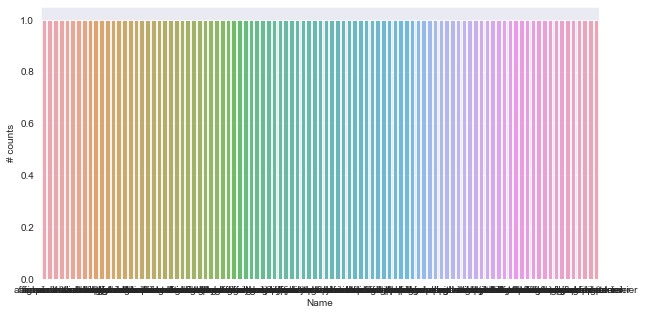

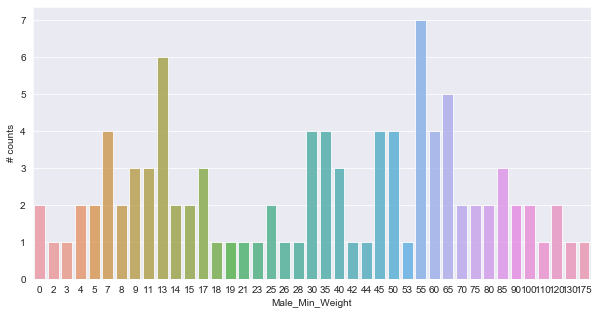

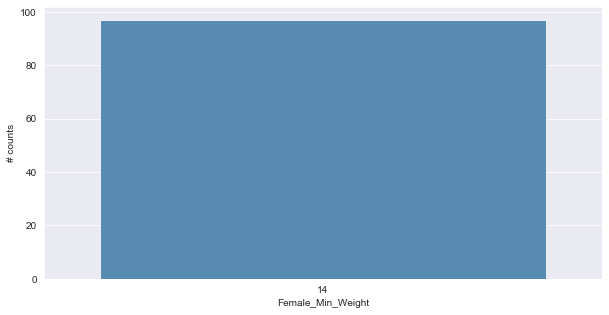

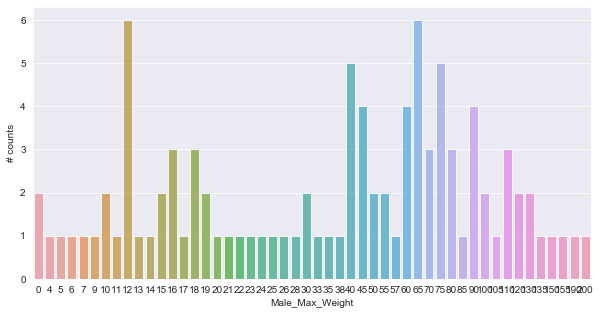

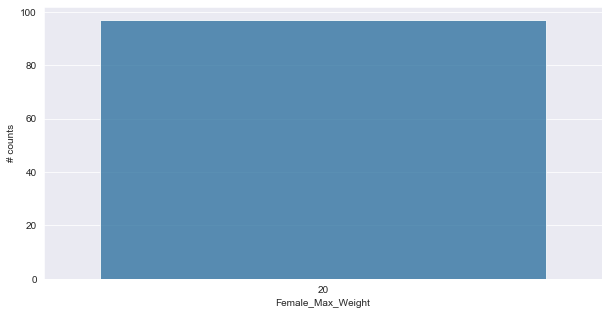

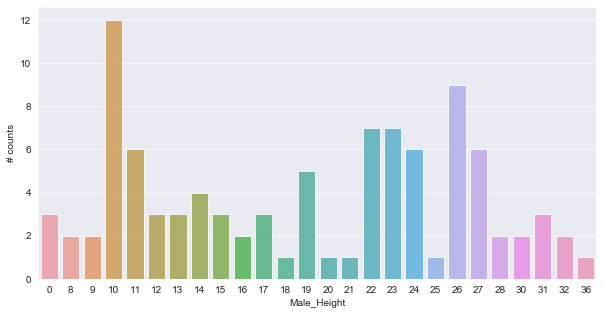

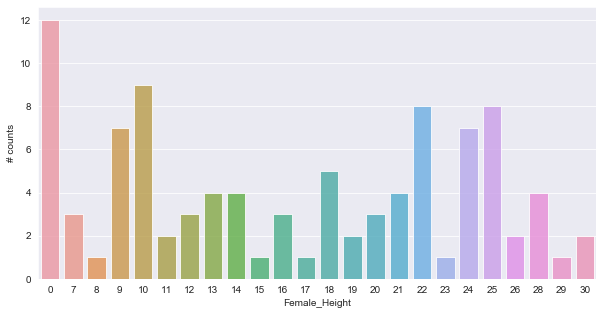

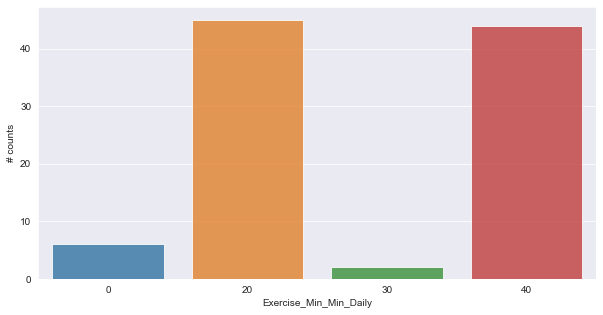

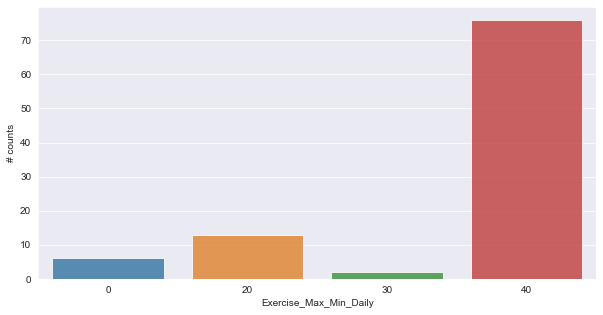

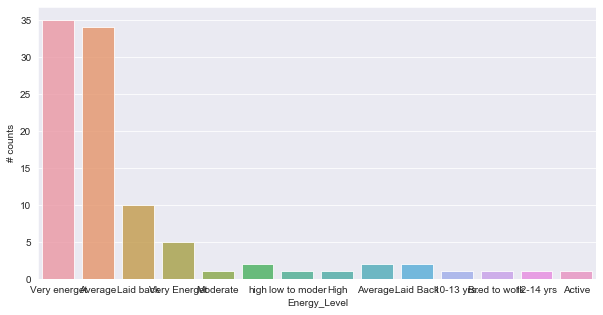

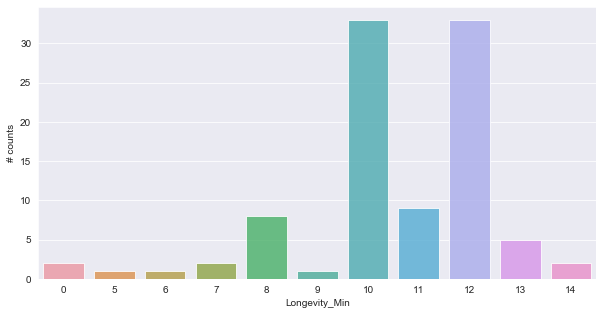

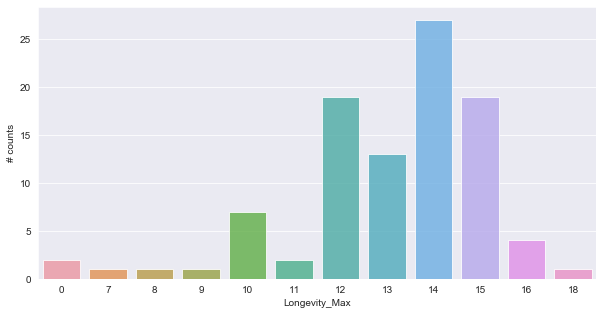

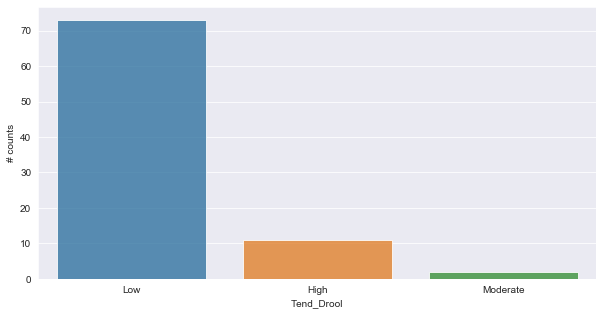

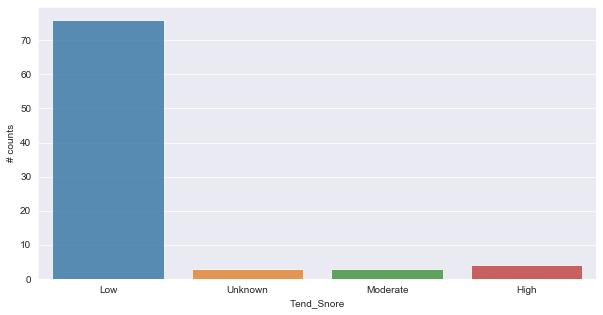

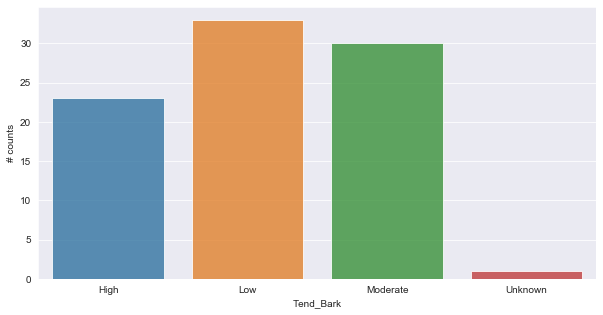

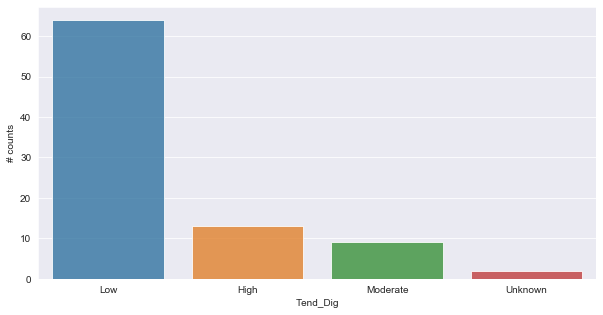

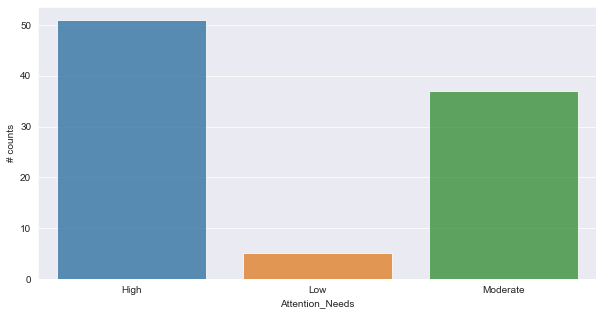

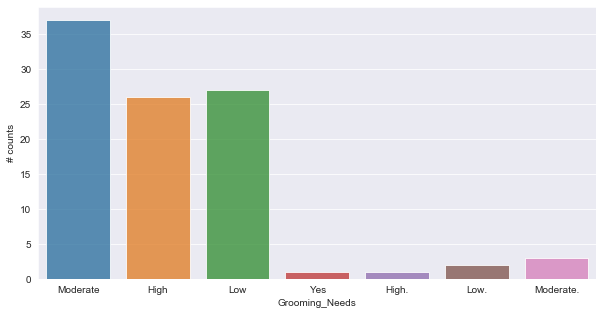

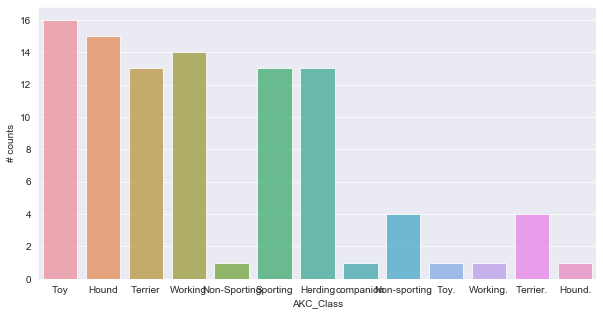

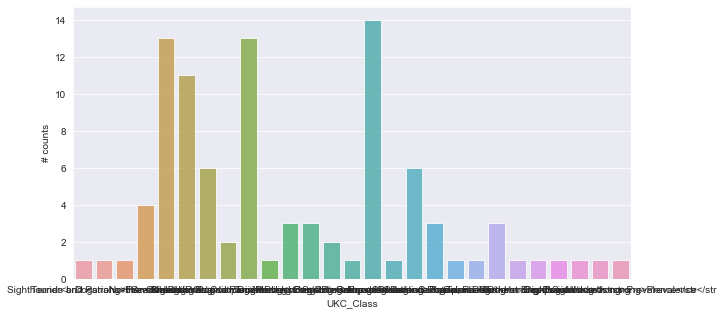

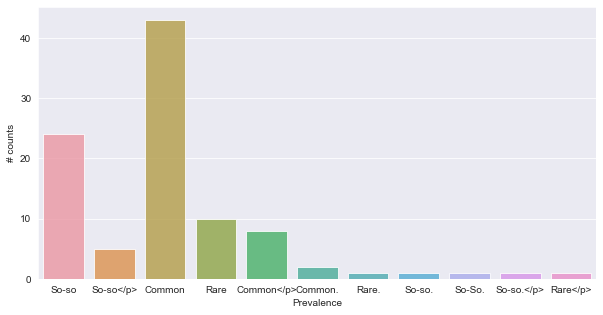

In [6]:
sns.set_style('darkgrid')

for column in list(df.columns):
    plt.figure(figsize = (10,5))
    sns.countplot(df[column], alpha =.80)
#     plt.title('Survivors vs Non-Survivors')
    plt.ylabel('# counts')
    plt.show()

# Cleaning columns

In [7]:
# Changing low medium high ranking to 0 ,1 ,2 respectivly

df['Tend_Drool'] = df['Tend_Drool'].map({'Low': 0, 'Moderate': 1, "High": 2})
df['Tend_Snore'] = df['Tend_Snore'].map({'Low': 0, 'Moderate': 1, "High": 2})
df['Tend_Dig'] = df['Tend_Dig'].map({'Low': 0, 'Moderate': 1, "High": 2})
df['Attention_Needs'] = df['Attention_Needs'].map({'Low': 0, 'Moderate': 1, "High": 2})
df['Tend_Bark'] = df['Tend_Bark'].map({'Low': 0, 'Moderate': 1, "High": 2, "Unknown": 1})
df['Grooming_Needs'] = df['Grooming_Needs'].map({'Low': 0, 'Moderate': 1, "High": 2, "Unknown": 1})

# breeds with years were checked by hand. terrier and working respectivly
df['Energy_Level'] = df['Energy_Level'].map({'Very energet': 2, 'Average': 1, "Laid back ": 0, "Very Energet": 2, "Average.": 1, "high": 2, 
                                             "Laid Back": 0, "Moderate": 1, "Active": 2, "12-14 yrs": 1, "Bred to work": 2, "High": 2, "low to moder": 0, "10-13 yrs.": 2 })                                                                         
                                             
df['Prevalence'] = df['Prevalence'].map({'Common': 0, 'So-so': 1, "Rare": 2, "Common</p>": 0, "So-so</p>.": 1, "Common.": 0,
                                         
     "So-So.": 1, 
    "So-so.": 1, "Rare.": 2, "So-so.</p>": 1, "Rare</p>": 2})    

#Mergeing Identical columns, final cleaning

df=df.replace(to_replace ="Non-Sporting", 
                 value ="Non-sporting") 
df=df.replace(to_replace ="companion", 
                 value ="Non-sporting") 
df=df.replace(to_replace ="Working.", 
                 value ="Working") 

df=df.replace(to_replace ="Toy.", 
                 value ="Toy") 


df=df.replace(to_replace ="Terrier.", 
                 value ="Terrier") 


df=df.replace(to_replace ="Hound.", 
                 value ="Hound")    

df= df.drop(['UKC_Class', "Name"], axis=1)

In [8]:
#Grouping AKC breeds inorder to reduce classes, scores proved unable to predict difference between group 3 inputs, so merged them into 1.
# group1= Toy
# group2=Working, Sporting
# group3=Terrier, Herding, Hound, Non-sporting

In [9]:
df['target']=['group1' if i =="Toy" else "group2" if i == "Working" or i == "Sporting" else "group3" for i in df.AKC_Class]

In [10]:
df= df.drop("AKC_Class", axis=1)

In [11]:
df=df.fillna(1)

In [12]:
#Setting X and Y data for all models.
Y= df.target
X= df.drop("target", axis=1)
for i in list(X.columns):
    X[i].astype(float)

In [13]:
#Splitting Data into test train, 20% test size.
X_train, X_test, y_train, y_test= train_test_split(X,Y, test_size=0.2, random_state=2)

In [14]:
#Functions for evaluating

def evaluate(test, pred, model):
    return [model, precision_score(test, pred, average= None), recall_score(test, pred, average= None), accuracy_score(test, pred), f1_score(test, pred, average= None)]
# print metrics
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average= None)))
    print("Recall Score: {}".format(recall_score(labels, preds, average= None)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average= None)))
# plot confusion metrix
def conf_metrix(model):
    # Create the basic matrix
    plt.imshow(model,  cmap=plt.cm.Blues)
    # Add title and axis labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Add appropriate axis scales
    class_names = set(y) # Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    # Add labels to each cell
    thresh = model.max() / 2. # Used for text coloring below
    # Here we iterate through the confusion matrix and append labels to our visualization
    for i, j in itertools.product(range(model.shape[0]), range(model.shape[1])):
            plt.text(j, i, model[i, j],
                     horizontalalignment='center',
                     color='white' if model[i, j] > thresh else 'black')
    # Add a legend
    plt.colorbar()
    plt.show()

# Dummy Baseline

In [15]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, Y)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(X)
#dummy accuracy
dummy_clf.score(X, Y)

0.5360824742268041

In [16]:
eva_dummy= evaluate(y_test, dummy_clf.predict(X_test), "Dummy")

# Decision Tree

In [17]:
tree_clf= DecisionTreeClassifier(max_depth= 10)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [18]:
tree_clf_pred= tree_clf.predict(X_test)

In [19]:
def gridsearchCV(model):
    param_grid={
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 10, 12],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6]}
    return GridSearchCV(model,param_grid, cv=3)

In [20]:
tree_clf_grid=gridsearchCV(tree_clf)
tree_clf_grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=10,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 12],
                      

In [21]:
tree_clf_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 5}

In [22]:
tree_clf_grid_pred= tree_clf_grid.predict(X_test)

In [23]:
evaluate(y_test, tree_clf_grid_pred, "Tree")

['Tree',
 array([0.66666667, 0.25      , 0.66666667]),
 array([1.        , 0.4       , 0.36363636]),
 0.5,
 array([0.8       , 0.30769231, 0.47058824])]

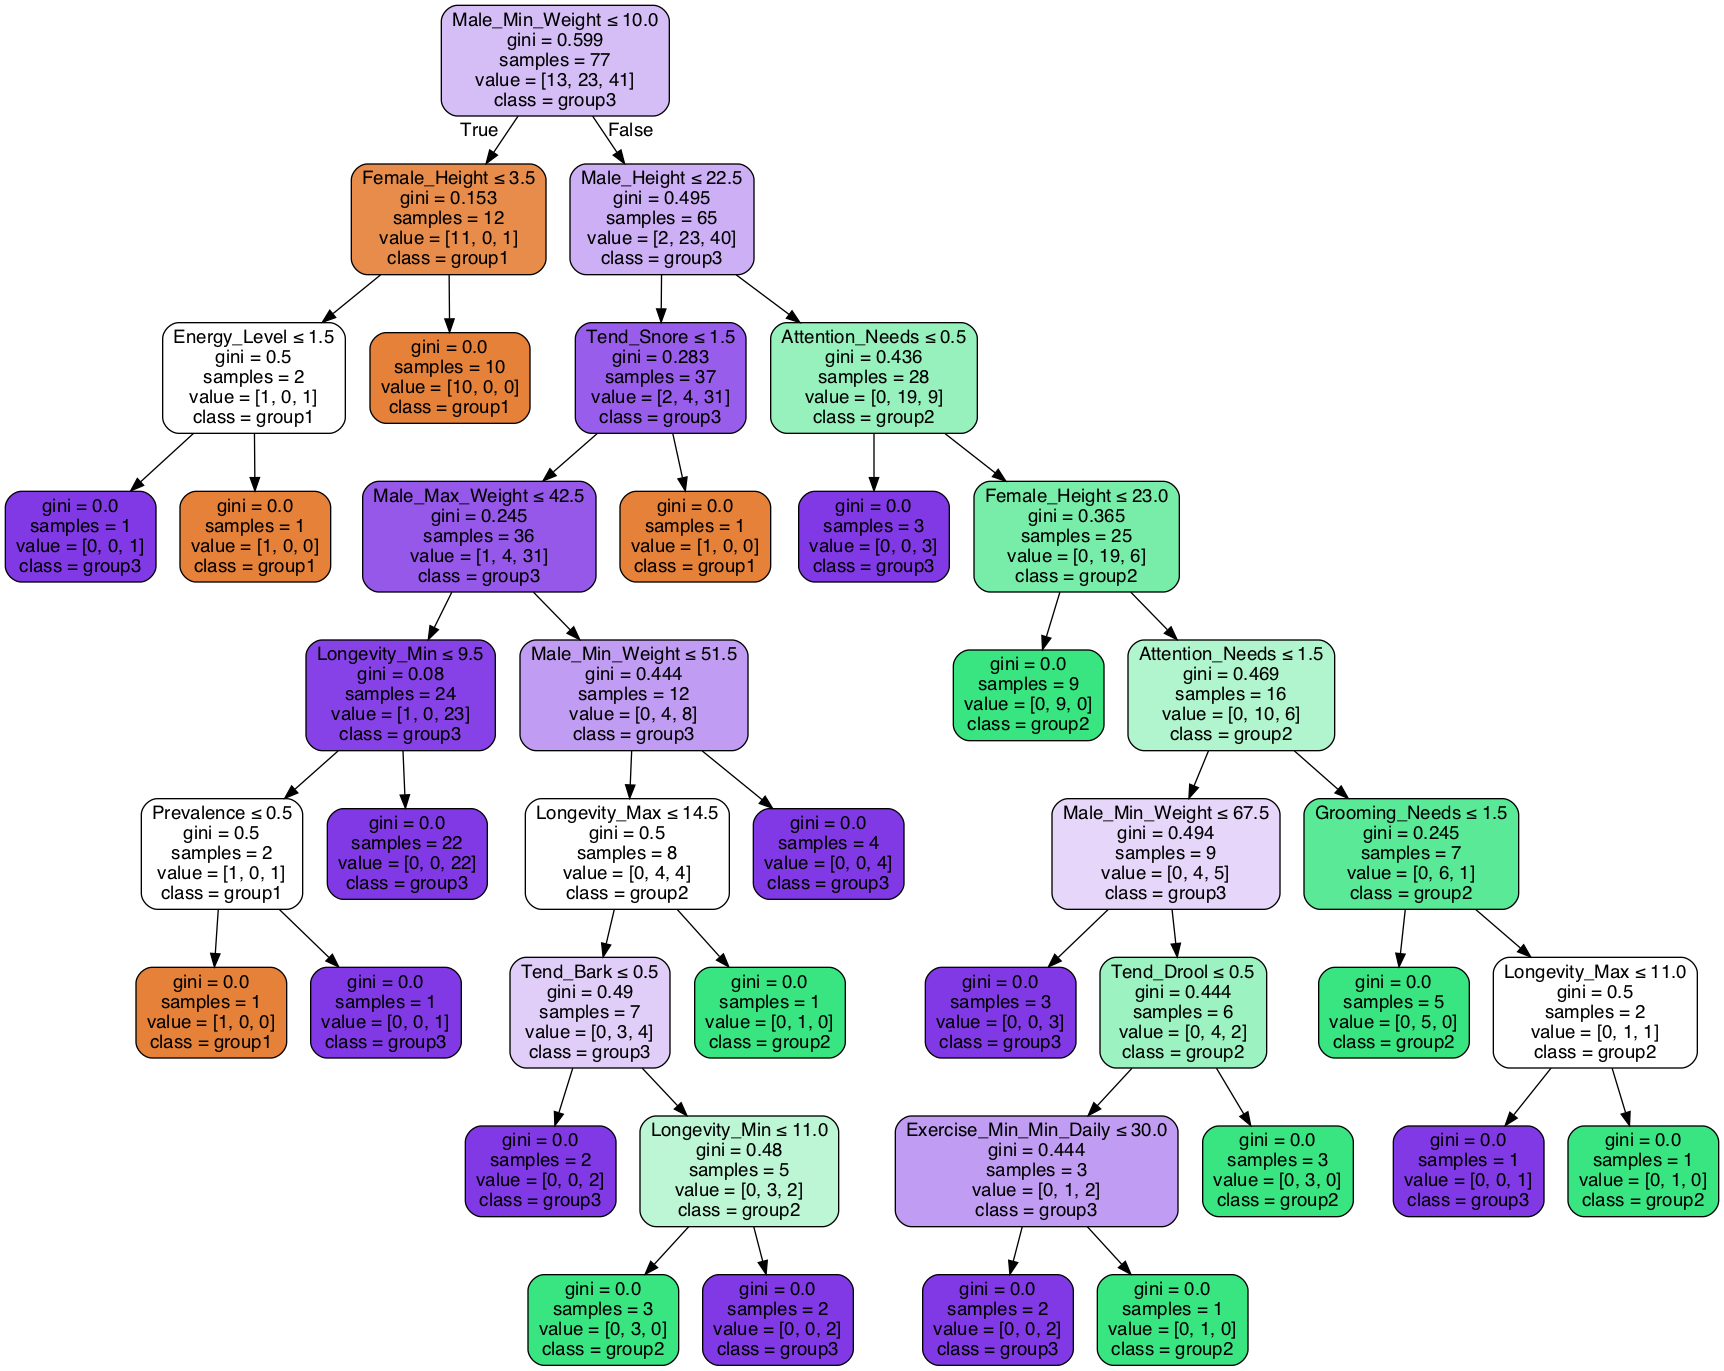

In [24]:
# Create DOT data
dot_data = export_graphviz(tree_clf, out_file=None,
                           feature_names=X_train.columns,
                           class_names=np.unique(Y).astype('str'),
                           filled=True, rounded=True, special_characters=True)
# Draw graph
graph = graph_from_dot_data(dot_data)
# Show graph
Image(graph.create_png())

# KNN

In [25]:
# Instantiate StandardScaler
scaler = StandardScaler().fit(X_train)

# Transform the training and test sets
scaled_data_train = scaler.transform(X_train)
scaled_data_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train)

In [26]:
# Instantiate KNeighborsClassifier
Kclf = KNeighborsClassifier(n_neighbors= 7)

# Fit the classifier
Kclf.fit(scaled_data_train, y_train)

# Predict on the test set
test_preds = Kclf.predict(scaled_data_test)

KNN_eva=evaluate(y_test, test_preds, 'KNN')

In [27]:
#Function to find the best KNN formula w/ Micro averaging
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 1):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds, average="micro")
        if f1 > best_score:
            best_k = k
            best_score = f1
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [28]:
find_best_k(scaled_data_train, y_train, scaled_data_test, y_test)

Best Value for k: 7
F1-Score: 0.65


In [70]:
KNN_confusion_matrix = confusion_matrix(y_test, test_preds)
KNN_confusion_matrix

array([[4, 0, 0],
       [0, 4, 1],
       [1, 5, 5]])

In [75]:
#Function to create confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(b= None)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[4 0 0]
 [0 4 1]
 [1 5 5]]


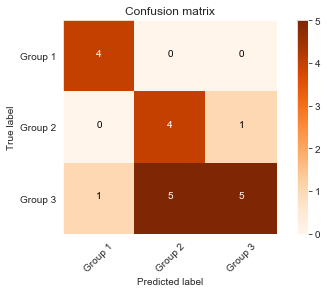

In [76]:
classes=["Group 1", "Group 2", "Group 3"]
plot_confusion_matrix(KNN_confusion_matrix, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges)

# Random Forrest

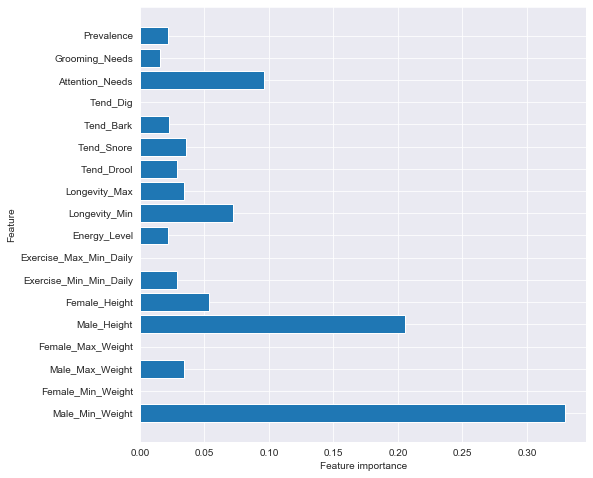

In [29]:
sds=tree_clf.feature_importances_
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree_clf)

In [30]:
pred = tree_clf.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[4 0 0]
 [0 3 2]
 [0 5 6]]
              precision    recall  f1-score   support

      group1       1.00      1.00      1.00         4
      group2       0.38      0.60      0.46         5
      group3       0.75      0.55      0.63        11

    accuracy                           0.65        20
   macro avg       0.71      0.72      0.70        20
weighted avg       0.71      0.65      0.66        20



In [31]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))

Testing Accuracy for Decision Tree Classifier: 65.0%


In [32]:
# Instantiating an BaggingClassifier
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=7), 
                                 n_estimators=20)

In [35]:
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=7,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
       

In [36]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth= 7)
gridsearchCV(forest)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=7,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='warn

In [37]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [38]:
forest_pred=forest.predict(X_test)

In [39]:
Forrests_eva=evaluate(y_test, forest_pred, 'Random Forrests')

# Adaboost and Gradient Boost


In [40]:
# Instantiate an AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(random_state=42)

# Instantiate an GradientBoostingClassifier
gbt_clf = GradientBoostingClassifier(random_state=42)

In [41]:
adaboost_clf.fit(X_train, y_train)
gbt_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [42]:
# AdaBoost model predictions
adaboost_train_preds = adaboost_clf.predict(X_train)
adaboost_test_preds = adaboost_clf.predict(X_test)

# GradientBoosting model predictions
gbt_clf_train_preds = gbt_clf.predict(X_train)
gbt_clf_test_preds = gbt_clf.predict(X_test)

In [43]:
ADA_eva=evaluate(y_test, adaboost_test_preds, 'AdaBoost')
GBT_eva=evaluate(y_test, gbt_clf_test_preds, 'GBT')

In [44]:
#Function to test Adaboost and gbt boost test vs train scores
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average='micro')
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
print("Training Metrics")
display_acc_and_f1_score(y_train, adaboost_train_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_train, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
print("Testing Metrics")
display_acc_and_f1_score(y_test, adaboost_test_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

Training Metrics
Model: AdaBoost
Accuracy: 0.7662337662337663
F1-Score: 0.7662337662337663

Model: Gradient Boosted Trees
Accuracy: 1.0
F1-Score: 1.0

Testing Metrics
Model: AdaBoost
Accuracy: 0.45
F1-Score: 0.45

Model: Gradient Boosted Trees
Accuracy: 0.45
F1-Score: 0.45


In [45]:
adaboost_confusion_matrix = confusion_matrix(y_test, adaboost_test_preds)
adaboost_confusion_matrix

array([[2, 0, 2],
       [0, 3, 2],
       [0, 7, 4]])

In [46]:
gbt_confusion_matrix = confusion_matrix(y_test, gbt_clf_test_preds)
gbt_confusion_matrix

array([[3, 0, 1],
       [0, 2, 3],
       [1, 6, 4]])

In [47]:
adaboost_classification_report = classification_report(y_test, adaboost_test_preds)
print(adaboost_classification_report)

              precision    recall  f1-score   support

      group1       1.00      0.50      0.67         4
      group2       0.30      0.60      0.40         5
      group3       0.50      0.36      0.42        11

    accuracy                           0.45        20
   macro avg       0.60      0.49      0.50        20
weighted avg       0.55      0.45      0.46        20



In [48]:
gbt_classification_report = classification_report(y_test, gbt_clf_test_preds)
print(gbt_classification_report)

              precision    recall  f1-score   support

      group1       0.75      0.75      0.75         4
      group2       0.25      0.40      0.31         5
      group3       0.50      0.36      0.42        11

    accuracy                           0.45        20
   macro avg       0.50      0.50      0.49        20
weighted avg       0.49      0.45      0.46        20



In [49]:
print('Mean GBT Cross-Val Score (k=5):')
print(cross_val_score(gbt_clf, X, Y, cv=5).mean())

Mean GBT Cross-Val Score (k=5):
0.6600668337510444


# XGBOOST

In [50]:
# Instantiate XGBClassifier
XG_clf = XGBClassifier()

# Fit XGBClassifier
XG_clf.fit(X_train, y_train)

# Predict on training and test sets
training_preds = XG_clf.predict(X_train)
XG_test_preds = XG_clf.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 100.0%
Validation accuracy: 65.0%


In [51]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [7],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [52]:
grid_clf = GridSearchCV(XG_clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 7
n_estimators: 100
subsample: 0.7

Training Accuracy: 100.0%
Validation accuracy: 65.0%


In [53]:
XGBoost_eva=evaluate(y_test, XG_test_preds, 'XGBoost')
XGBoost_eva

['XGBoost',
 array([0.8       , 0.33333333, 0.66666667]),
 array([1.        , 0.4       , 0.54545455]),
 0.6,
 array([0.88888889, 0.36363636, 0.6       ])]

# SVM

In [54]:
svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [55]:
svm_pred= svm_clf.predict(X_test)

In [56]:
print_metrics(y_test, svm_pred)
SVM_eva=evaluate(y_test, svm_pred, 'SVM')

Precision Score: [1.         0.4        0.66666667]
Recall Score: [0.75       0.4        0.72727273]
Accuracy Score: 0.65
F1 Score: [0.85714286 0.4        0.69565217]


# Logistical Regression

In [57]:
min_max = MinMaxScaler().fit(X_train)
X_train_sca = min_max.transform(X_train)
X_test_sca = min_max.transform(X_test)

# created model
# check the running time
import time
start = time.time()
log_clf = LogisticRegression()
log_clf.fit(X_train_sca, y_train)
log_runtime = time.time() - start

# prediction of  the test set
log_pred = log_clf.predict(X_test_sca)

# evaluated metrix for result table
log_eva = evaluate(y_test, log_pred, 'Logistic Regression ')

# Results

In [58]:
#Building a matrix of all test data
log_eva = evaluate(y_test, log_pred, 'Logistic Regression ')
Tree_eva=evaluate(y_test, tree_clf_grid_pred, 'Decision Tree')
Forrests_eva=evaluate(y_test, forest_pred, 'Random Forrests')
KNN_eva=evaluate(y_test, test_preds, 'KNN')
ADA_eva=evaluate(y_test, adaboost_test_preds, 'AdaBoost')
GBT_eva=evaluate(y_test, gbt_clf_test_preds, 'GBT')
XGBoost_eva=evaluate(y_test, XG_test_preds, 'XGBoost')
SVM_eva=evaluate(y_test, svm_pred, 'SVM')

In [59]:
results= pd.DataFrame()

In [60]:
results= results.append([eva_dummy, log_eva, Tree_eva, Forrests_eva, KNN_eva, ADA_eva, 
                         GBT_eva, XGBoost_eva, SVM_eva])

In [61]:
results.columns=["Model", "Precision Score", "Recall Score", "Accuracy Score", "F1 Score"]
results

,Model,Precision Score,Recall Score,Accuracy Score,F1 Score
0,Dummy,"[0.0, 0.0, 0.55]","[0.0, 0.0, 1.0]",0.55,"[0.0, 0.0, 0.7096774193548387]"
1,Logistic Regression,"[0.0, 0.4, 0.5714285714285714]","[0.0, 0.4, 0.7272727272727273]",0.50,"[0.0, 0.4000000000000001, 0.64]"
2,Decision Tree,"[0.6666666666666666, 0.25, 0.6666666666666666]","[1.0, 0.4, 0.36363636363636365]",0.50,"[0.8, 0.3076923076923077, 0.4705882352941177]"
3,Random Forrests,"[0.8, 0.3, 0.6]","[1.0, 0.6, 0.2727272727272727]",0.50,"[0.888888888888889, 0.4, 0.37499999999999994]"
4,KNN,"[0.8, 0.4444444444444444, 0.8333333333333334]","[1.0, 0.8, 0.45454545454545453]",0.65,"[0.888888888888889, 0.5714285714285714, 0.5882..."
5,AdaBoost,"[1.0, 0.3, 0.5]","[0.5, 0.6, 0.36363636363636365]",0.45,"[0.6666666666666666, 0.4, 0.4210526315789474]"
6,GBT,"[0.75, 0.25, 0.5]","[0.75, 0.4, 0.36363636363636365]",0.45,"[0.75, 0.3076923076923077, 0.4210526315789474]"
7,XGBoost,"[0.8, 0.3333333333333333, 0.6666666666666666]","[1.0, 0.4, 0.5454545454545454]",0.60,"[0.888888888888889, 0.3636363636363636, 0.6]"
8,SVM,"[1.0, 0.4, 0.6666666666666666]","[0.75, 0.4, 0.7272727272727273]",0.65,"[0.8571428571428571, 0.4000000000000001, 0.695..."


In [62]:
#getting matrix with Weighted Scores
def evaluate_weighted(test, pred, model):
    return [model, precision_score(test, pred, average= "weighted"), recall_score(test, pred, average= "weighted"),
            accuracy_score(test, pred), f1_score(test, pred, average= "weighted")]

In [63]:
eva_dummy2= evaluate_weighted(y_test, dummy_clf.predict(X_test), "Dummy")
log_eva2 = evaluate_weighted(y_test, log_pred, 'Logistic Regression ')
Tree_eva2=evaluate_weighted(y_test, tree_clf_grid_pred, 'Decision Tree')
Forrests_eva2=evaluate_weighted(y_test, forest_pred, 'Random Forrests')
KNN_eva2=evaluate_weighted(y_test, test_preds, 'KNN')
ADA_eva2=evaluate_weighted(y_test, adaboost_test_preds, 'AdaBoost')
GBT_eva2=evaluate_weighted(y_test, gbt_clf_test_preds, 'GBT')
XGBoost_eva2=evaluate_weighted(y_test, XG_test_preds, 'XGBoost')
SVM_eva2=evaluate_weighted(y_test, svm_pred, 'SVM')

In [64]:
results_weighted= pd.DataFrame()

In [65]:
results_weighted= results_weighted.append([eva_dummy2, log_eva2, Tree_eva2,
                                        Forrests_eva2, KNN_eva2, ADA_eva2, GBT_eva2, 
                                           XGBoost_eva2, SVM_eva2])


In [66]:
results_weighted.columns=["Model", "Precision Score", "Recall Score", "Accuracy Score", "F1 Score"]

In [67]:
results_weighted

,Model,Precision Score,Recall Score,Accuracy Score,F1 Score
0,Dummy,0.302500,0.55,0.55,0.390323
1,Logistic Regression,0.414286,0.50,0.50,0.452000
2,Decision Tree,0.562500,0.50,0.50,0.495747
3,Random Forrests,0.565000,0.50,0.50,0.484028
4,KNN,0.729444,0.65,0.65,0.644164
5,AdaBoost,0.550000,0.45,0.45,0.464912
6,GBT,0.487500,0.45,0.45,0.458502
7,XGBoost,0.610000,0.60,0.60,0.598687
8,SVM,0.666667,0.65,0.65,0.654037
